Andrea Hanel 2024

# CC phase proportion test (sc-level)

- Propeller tutorial: https://bioconductor.org/packages/devel/bioc/vignettes/speckle/inst/doc/speckle.html
- Benchmarking paper highlighting propeller with asin normalization: Simmons, biorxiv https://doi.org/10.1101/2022.02.04.479123

In [2]:
library(speckle)
library(SingleCellExperiment)
#library(CellBench)
library(limma)
library(ggplot2)
library(scater)
library(patchwork)
library(edgeR)
#library(statmod)
library(anndata)
library(dplyr)

#to be able to adjust figs
fig <- function(width, heigth){
options(repr.plot.width = width, repr.plot.height = heigth) }

In [3]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.4 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /research/users/andreha/miniconda3/envs/traj_inf/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.utf8         LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Helsinki
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dplyr_1.1.3                 anndata_0.7.5.6            
 [3] edgeR_3.42.4                patchwork_1.1.3            
 [5] scater_1.28.0               scuttle_1.10.1             
 [7

In [3]:
adata = read_h5ad ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_PCAharmony_leiden_LS.h5ad")
adata$obs$Level1 = factor(adata$obs$'Level 1')  

log1p_norm_data <- as.matrix(adata$layers[["log1p_norm"]])
raw_data <- as.matrix(adata$layers[["raw_counts"]])

pca_coords <- as.matrix(adata$obsm[["X_pca"]])   # PCA coordinates
umap_coords <- as.matrix(adata$obsm[["X_umap"]]) # UMAP coordinates
fa_coords <- as.matrix (adata$obsm[["X_draw_graph_fa"]])

colnames(pca_coords) <- paste0("PC_", seq_len(ncol(pca_coords)))
colnames(umap_coords) <- paste0("UMAP_", seq_len(ncol(umap_coords)))
colnames(fa_coords) <- paste0("FA_", seq_len(ncol(fa_coords)))


sce <- SingleCellExperiment(
    assays = list(counts = t(raw_data), 
                  logcounts = t(log1p_norm_data)), 
    colData = data.frame(adata$obs)
)

reducedDims(sce) <- list(PCA = pca_coords, UMAP = umap_coords,
                        FA = fa_coords)

In [8]:
obs_df <- as.data.frame(adata$obs)
head(obs_df, n=2)

,sample,etv6_runx1,barcode,n_counts,log_counts,n_genes,mt_frac,celline,leiden_res0_25,S_score,G2M_score,phase,phase_combined,S/G2M_score_combined,Level 1,Level 2,Max-Rho,Combined Correlation DiffScore,Level1
,<ord>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
AAACCCAAGCGAACTG-1,HW8_WT,WT,AAACCCAAGCGAACTG-1,29339,10.28667,5978,0.07399707,HW8,1,-0.2908289,-0.2839419,G1,G1,-0.2873854,MEP,Erythroid,0.3792551,0.2483093,MEP
AAACCCACAAGAGTTA-1,HW8_WT,WT,AAACCCACAAGAGTTA-1,37476,10.53146,7159,0.04680329,HW8,1,-0.1458094,0.8749851,G2M,G2M/S,0.3645878,MKP,Megakaryocytic,0.4937613,0.1290702,MKP


In [9]:
obs_df <- as.data.frame(adata$obs)
#head(obs_df)

#obs_df$sample_short = paste0(obs_df$celline, "_", obs_df$etv6_runx1)
#obs_df$sample_short = factor(obs_df$sample_short, levels = c("HW8_WT", "HW8_KI", "ChiPSC12_WT", "ChiPSC12_KI"))  # Convert to factor with specified levels


d <- obs_df %>%
  dplyr::count(phase_combined, sample)
head(d)

,phase_combined,sample,n
,<fct>,<ord>,<int>
1,G1,ChiPSC12_ETV6_RUNX1_KI,8463
2,G1,HW8_ETV6_RUNX1_KI,6366
3,G1,ChiPSC12_WT,3547
4,G1,HW8_WT,3792
5,G2M/S,ChiPSC12_ETV6_RUNX1_KI,1996
6,G2M/S,HW8_ETV6_RUNX1_KI,2461


In [10]:
#sce$sample <- sample
sce$group <- sce$etv6_runx1
sce$cluster <- sce$phase_combined

In [11]:
sce

class: SingleCellExperiment 
dim: 33233 32358 
metadata(0):
assays(2): counts logcounts
rownames(33233): MIR1302-2HG AL627309.1 ... AC007325.4 AC007325.2
rowData names(0):
colnames(32358): AAACCCAAGCGAACTG-1 AAACCCACAAGAGTTA-1 ...
  TTTGTTGTCCGTATAG-4 TTTGTTGTCGTAGGAG-4
colData names(21): sample etv6_runx1 ... group cluster
reducedDimNames(3): PCA UMAP FA
mainExpName: NULL
altExpNames(0):

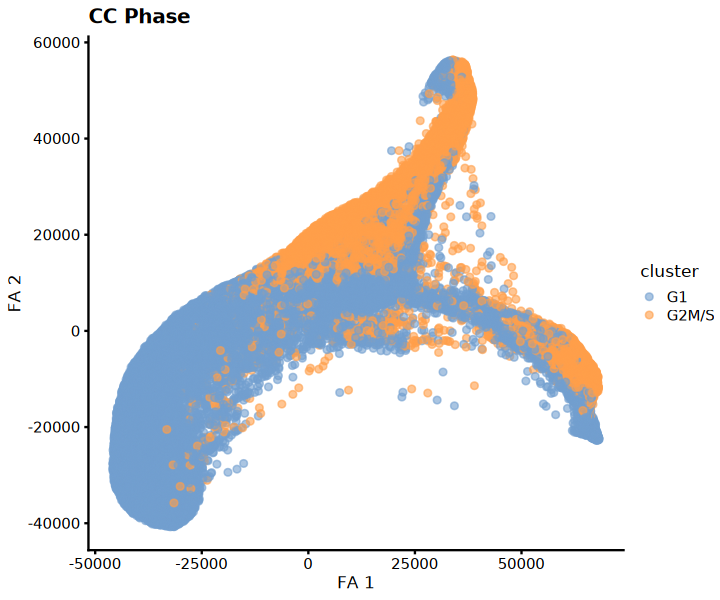

In [12]:
fig(6,5)

scater::plotReducedDim(sce, dimred = "FA", 
                                colour_by = "cluster") + 
    ggtitle("CC Phase")

## Logit normalization (default)

In [14]:
propeller(clusters=sce$phase_combined, 
          sample=sce$sample,
          group=sce$etv6_runx1)


Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Setting robust to FALSE for eBayes for less than 3 cell types



,BaselineProp.clusters,BaselineProp.Freq,PropMean.KI,PropMean.WT,PropRatio,Tstatistic,P.Value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G2M/S,G2M/S,0.3149144,0.234822,0.4384234,0.5356057,-3.604874,0.02265964,0.02265964
G1,G1,0.6850856,0.765178,0.5615766,1.3625531,3.604874,0.02265964,0.02265964


## Asin normalization

In [15]:
propeller(clusters=sce$phase_combined, 
          sample=sce$sample,
          group=sce$etv6_runx1, 
          transform="asin")

Performing arcsin square root transformation of proportions

group variable has 2 levels, t-tests will be performed

Setting robust to FALSE for eBayes for less than 3 cell types



,BaselineProp.clusters,BaselineProp.Freq,PropMean.KI,PropMean.WT,PropRatio,Tstatistic,P.Value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G2M/S,G2M/S,0.3149144,0.234822,0.4384234,0.5356057,-3.864181,0.01808277,0.01808277
G1,G1,0.6850856,0.765178,0.5615766,1.3625531,3.864181,0.01808277,0.01808277


extracting sample information from SingleCellExperiment object

Performing logit transformation of proportions



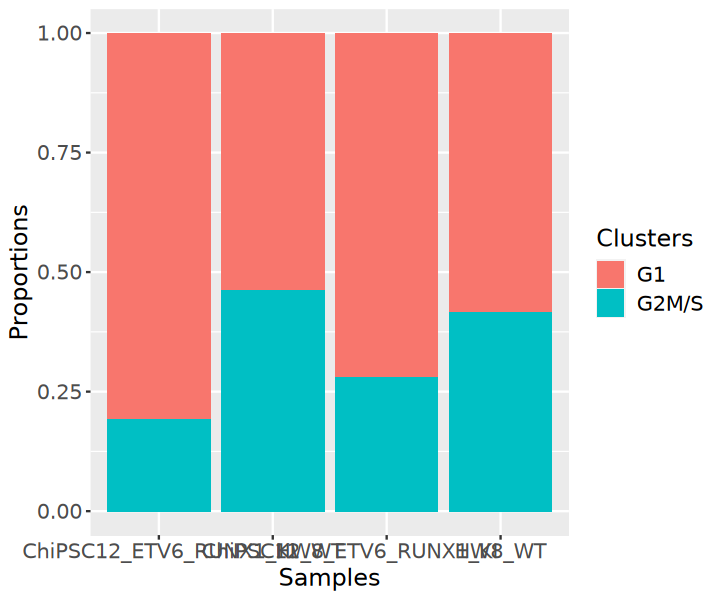

In [32]:
plotCellTypeProps(sce)

Performing logit transformation of proportions



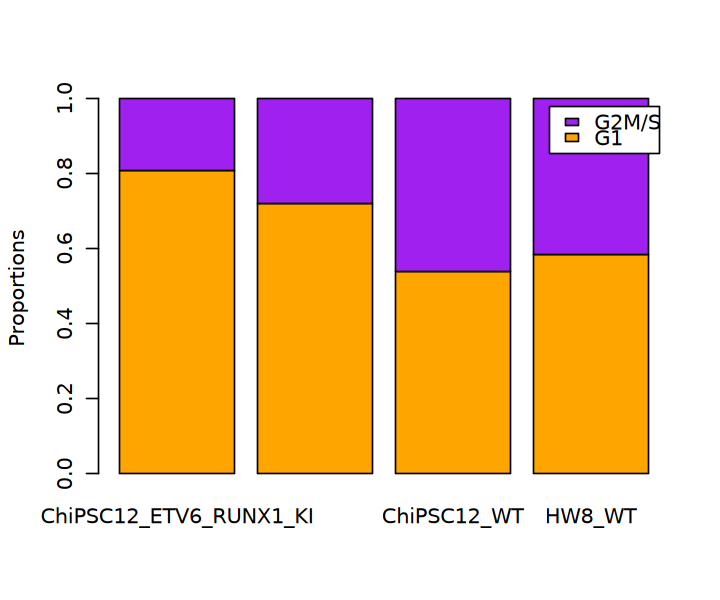

In [31]:
props <- getTransformedProps(sce$phase_combined, sce$sample, transform="logit")

fig(5,6)
barplot(props$Proportions, col = c("orange","purple","dark green"),legend=TRUE, 
        ylab="Proportions")

In [ ]:
props <- getTransformedProps(sce$phase_combined, sce$sample, transform="asin")

fig(5,6)
barplot(props$Proportions, col = c("orange","purple","dark green"),legend=TRUE, 
        ylab="Proportions")